Interacting with manifold
====================
The basic interface of _StochMan_ is that you first define a manifold, and then use this to compute geodesics, etc. The manifold objects will generally depend on data as the focus of _StochMan_ is on _learning manifolds_. As a first simple example of how to engage with manifolds once they have been constructed. We therefore start with with a pre-implemented manifold that correspond to the paper:

_A Locally Adaptive Normal Distribution_  
Georgios Arvanitidis, Lars Kai Hansen, and Søren Hauberg.  
Neural Information Processing Systems (NeurIPS), 2016.  

Here the observation space is endowed with a Riemannian metric which is simply the inverse covariance of data computed locally.

To get started we import relevant modules

In [55]:
#!/usr/bin/env python3
import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch, time
import torchplot as plt
from torchvision.datasets import MNIST
from sklearn.decomposition import PCA

import stochman

We'll be using MNIST as a toy example to get started. We select 1000 observations of one-digits and perform PCA to get a two-dimensional representation. We do this to ensure that we can visualize the results.

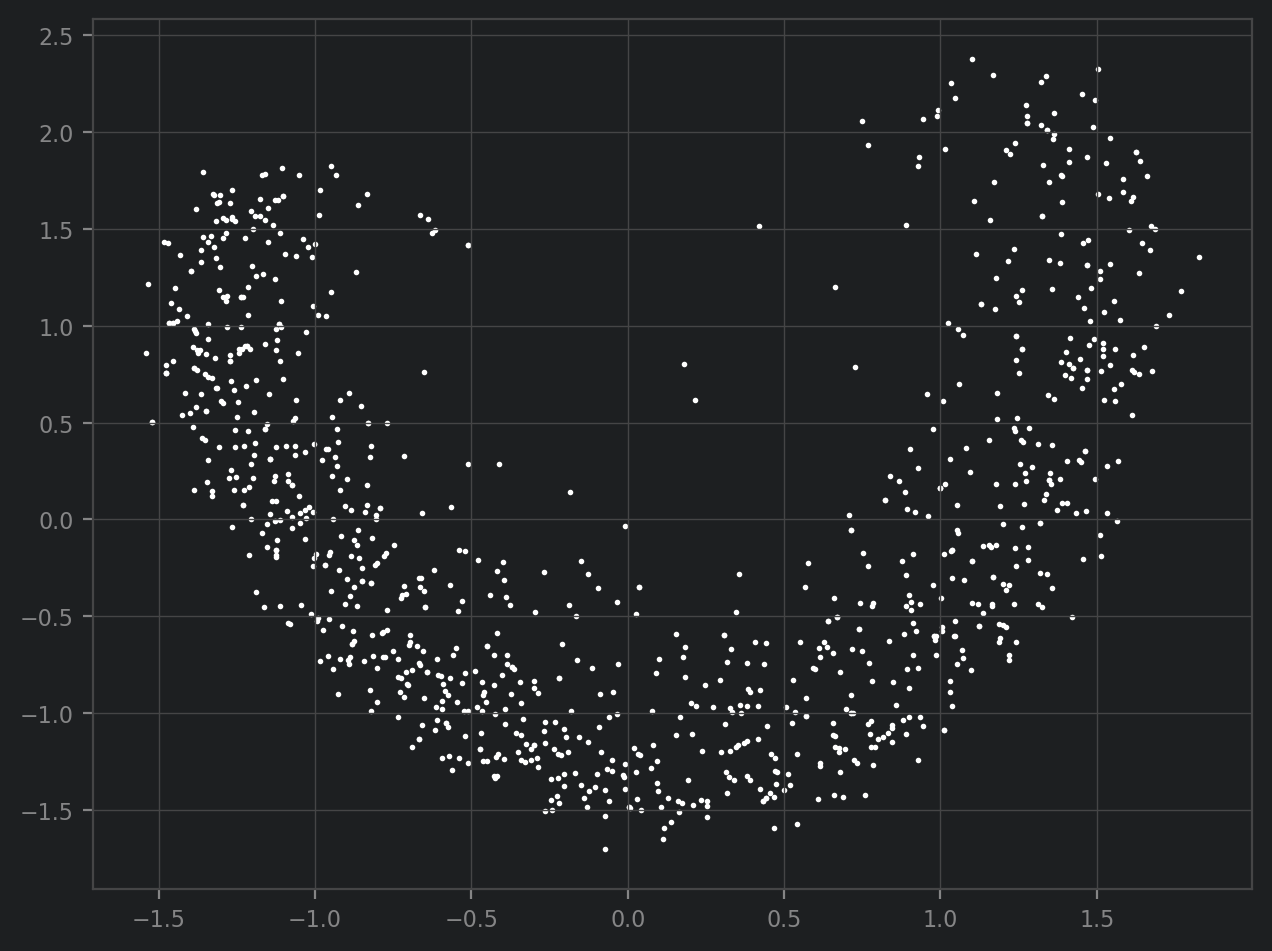

In [56]:
def get_subset_mnist(n: int = 1000):
    dataset = MNIST(root="", download=True)
    idx_ones = dataset.targets == 1
    mnist_ones = dataset.data[idx_ones].to(torch.float32)
    N = mnist_ones.shape[0]
    idx = torch.randint(N, [n,])
    data = mnist_ones[idx].reshape(n, -1).numpy()
    low_dim_data = torch.from_numpy(PCA(n_components=2).fit_transform(data))
    return low_dim_data / low_dim_data.std(dim=0, keepdim=True)

# Read data
data = get_subset_mnist(n=1000)
data = data
N, D = data.shape
# N, D
plt.scatter(data[:, 0], data[:, 1], s=1, c="w")

Next we construct the manifold using the predefined _LocalVarMetric_ class.

In [57]:
# Parameters for metric
sigma = 0.1
rho = 0.1

# Create metric
M = stochman.manifold.LocalVarMetric(data=data, sigma=sigma, rho=rho)

In [58]:
data[0:10]
# M.metric()

tensor([[ 1.0062, -0.5762],
        [-0.8221, -0.9882],
        [ 1.3500,  0.2393],
        [ 1.4530,  0.6767],
        [-1.1241,  0.8740],
        [-0.5798, -1.0518],
        [ 0.6684, -0.5063],
        [-0.8002, -0.9450],
        [ 1.0053, -0.5566],
        [-0.2467, -1.4504]])

We now have a manifold to play around with. As a starting point, we will evaluate the volume measure (sometimes also called to _magnification_ _factor_ associated with the manifold in order to visualize the data and the metric.

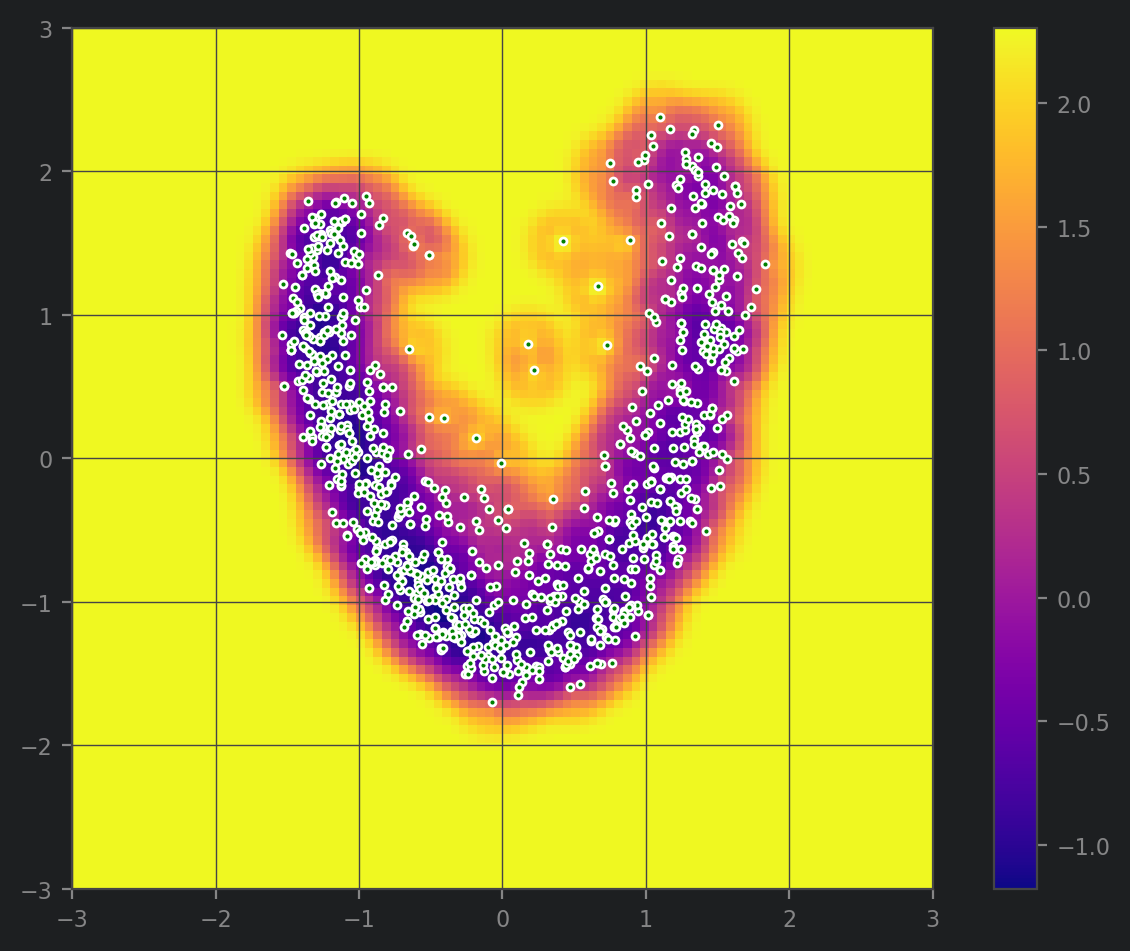

In [59]:
# Plot metric and data
with torch.no_grad():
    ran = torch.linspace(-3., 3., 100)
    gridX, gridY = torch.meshgrid([ran, ran])
    grid = torch.stack((gridX.flatten(), gridY.flatten()), dim=1)  # 10000x2
    magfac = M.log_volume(grid)  # 10000
plt.imshow(magfac.view(100, 100).numpy().T, extent=(ran[0], ran[-1], ran[0], ran[-1]), origin="lower")
plt.colorbar()
plt.plot(data[:, 0].numpy(), data[:, 1].numpy(), '.', markersize=5, markeredgecolor="w", markerfacecolor="g")

In [79]:
# Compute geodesics in parallel
p0 = data[torch.randint(high=N, size=[10], dtype=torch.long)]  # 10xD
p1 = data[torch.randint(high=N, size=[10], dtype=torch.long)]  # 10xD
p0.shape, p1.shape

(torch.Size((10, 2)), torch.Size((10, 2)))

In [93]:
t0 = time.time()
C, success = M.connecting_geodesic(p0, p1)
print("Time elapsed: ", time.time() - t0)

torch.Size([10, 2])
Time elapsed:  2.6982359886169434


torch.Size((10, 4, 4, 2))

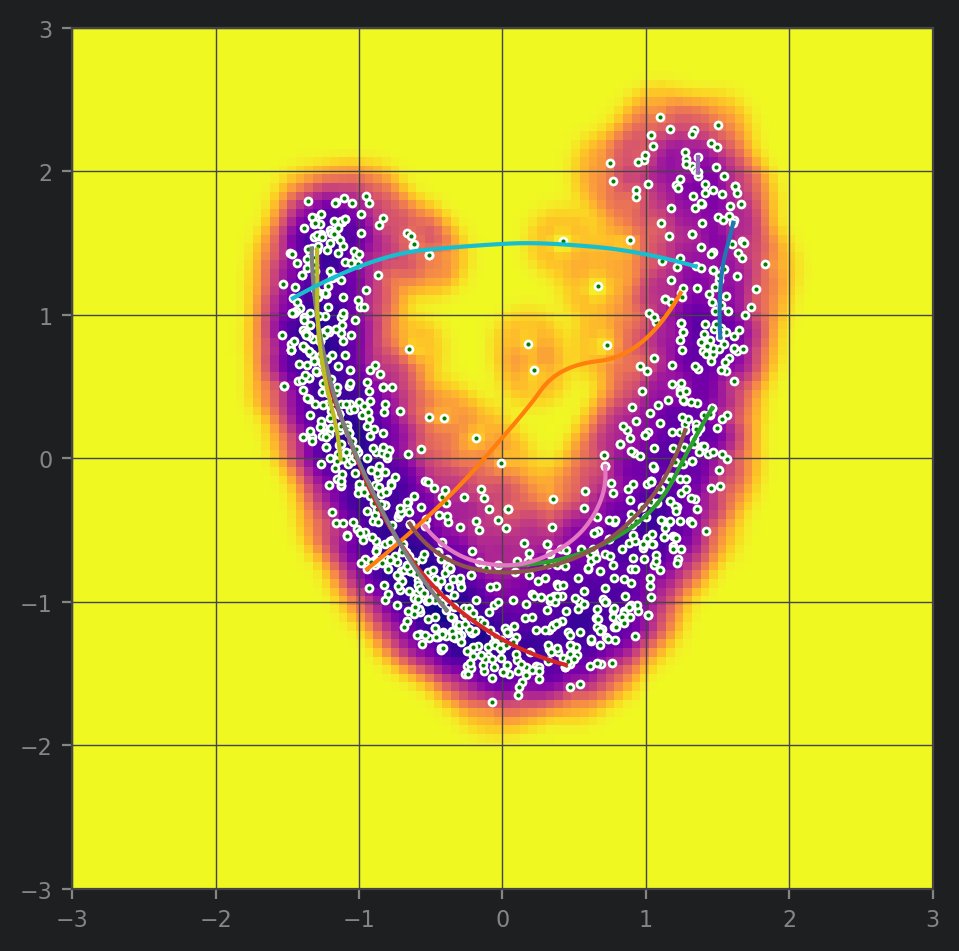

In [94]:
plt.imshow(magfac.view(100, 100).numpy().T, extent=(ran[0], ran[-1], ran[0], ran[-1]), origin="lower")
plt.plot(data[:, 0].numpy(), data[:, 1].numpy(), '.', markersize=5, markeredgecolor="w", markerfacecolor="g")
C.plot();
C._get_coeffs().shape

torch.Size((10, 4, 4, 2))

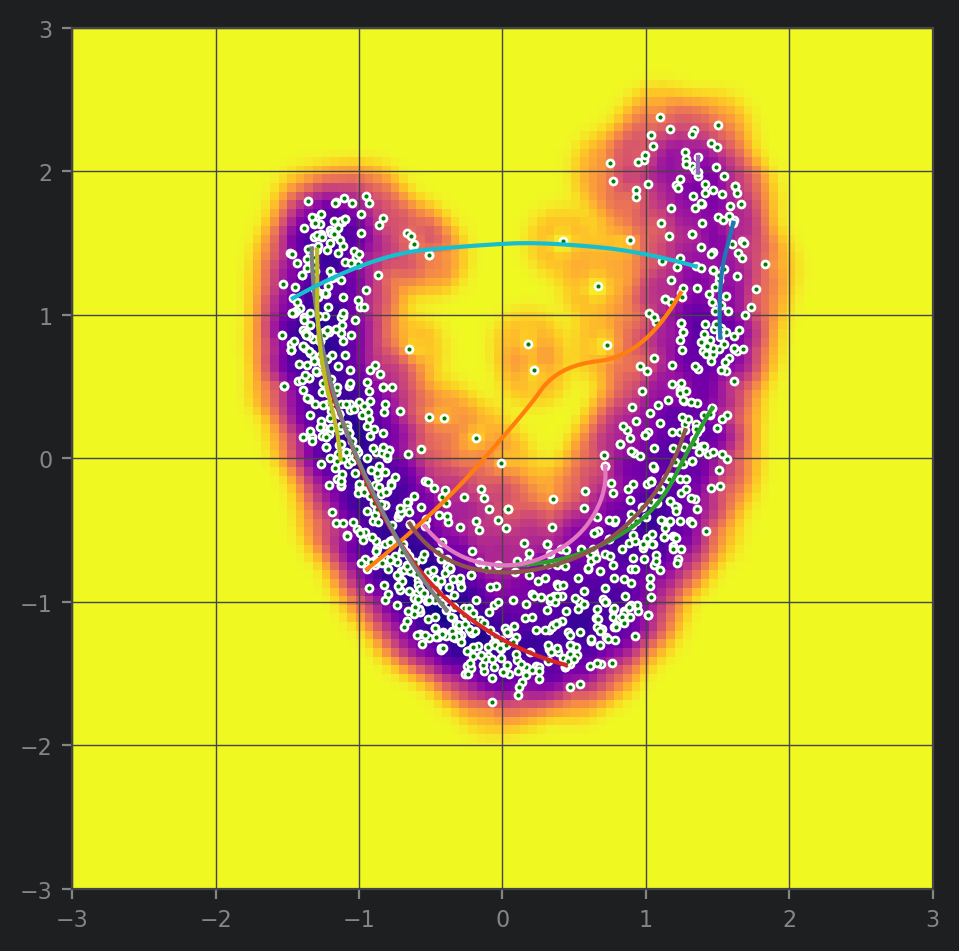

In [91]:
plt.imshow(magfac.view(100, 100).numpy().T, extent=(ran[0], ran[-1], ran[0], ran[-1]), origin="lower")
plt.plot(data[:, 0].numpy(), data[:, 1].numpy(), '.', markersize=5, markeredgecolor="w", markerfacecolor="g")
C.plot();
C._get_coeffs().shape

tensor([[[[ 0.0000,  0.0000],
          [-0.0784, -0.0787],
          [ 0.3908,  0.1950],
          [-0.3124, -0.1162]]]], grad_fn=<ViewBackward0>)

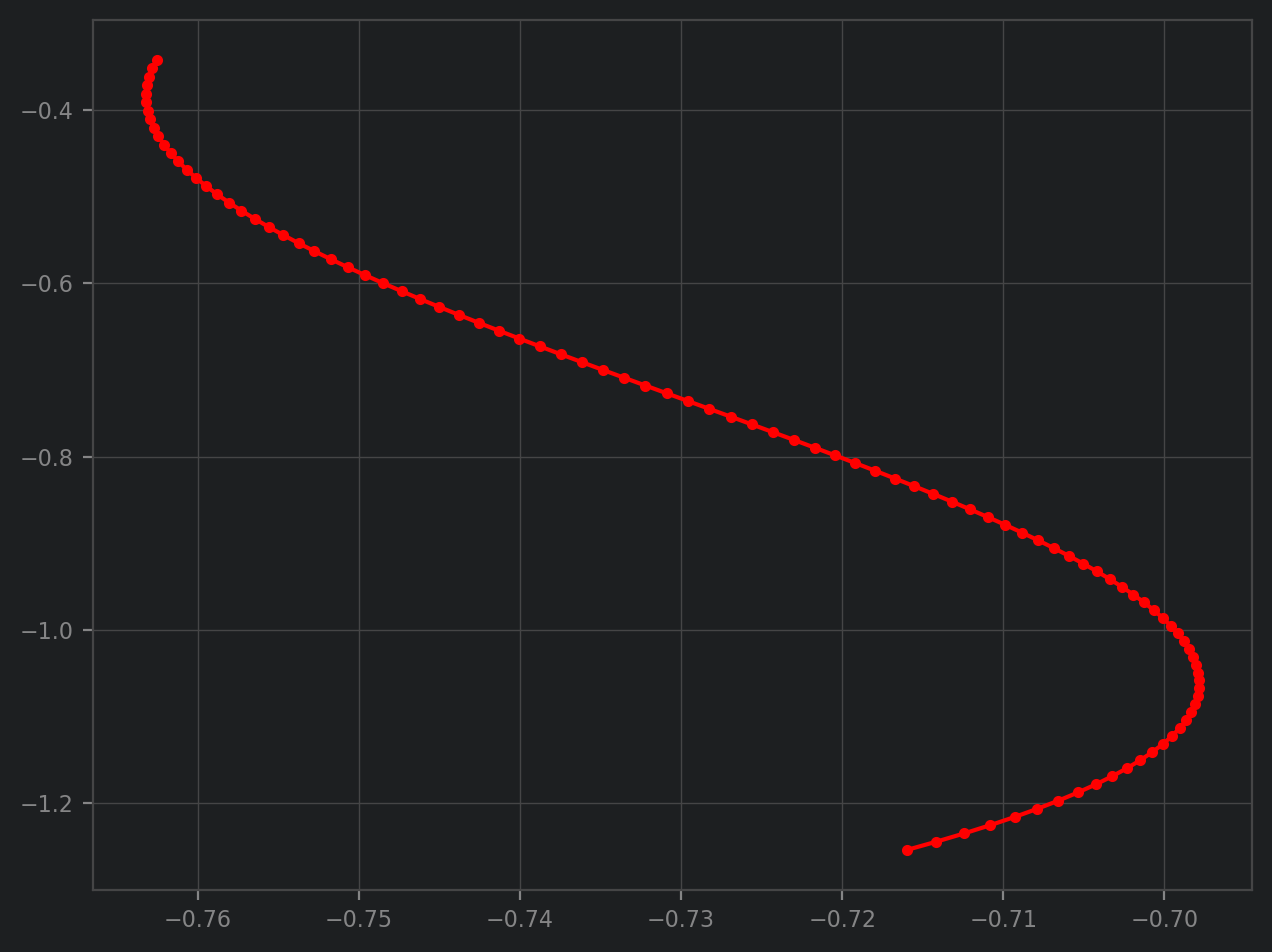

In [9]:
# Compute shooting geodesic as a sanity check
p0 = data[0]  # 1xD
p1 = data[5]  # 1xD

C, success = M.connecting_geodesic(p0, p1, num_nodes=2)

evld = C(torch.linspace(0, 1, 100))#._get_coeffs().shape
evld.shape
# M.curve_energy(evld)
plt.plot(evld[:, 0], evld[:, 1], "r.-");
C._get_coeffs()
# plt.imshow(magfac.view(100, 100).numpy().T, extent=(ran[0], ran[-1], ran[0], ran[-1]), origin="lower")
# plt.plot(data[:, 0].numpy(), data[:, 1].numpy(), "k.", markersize=1)
#C.plot(0, 1, 10, None, "w.-")
# C._get_coeffs()

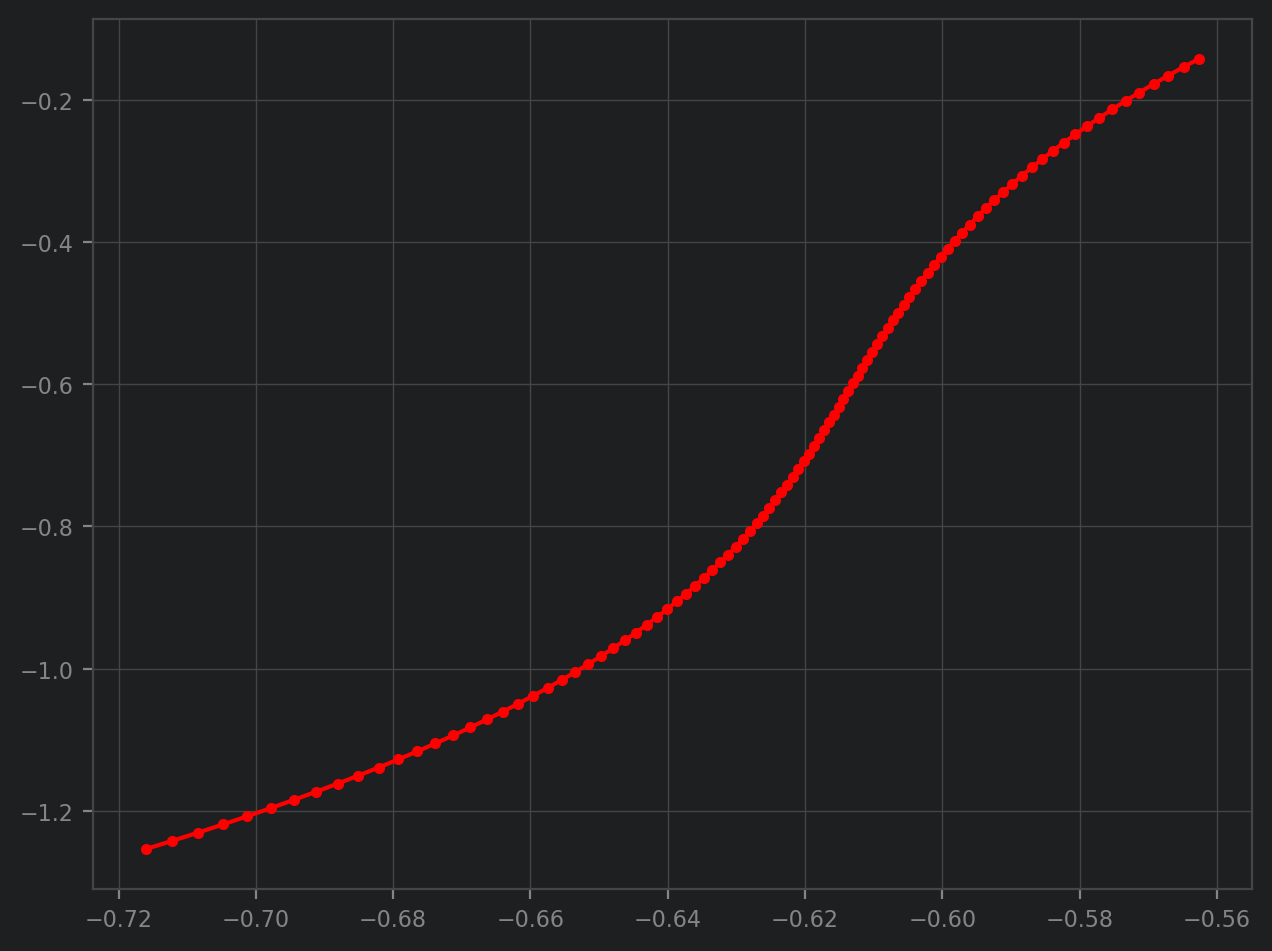

In [10]:
C.begin +=0.2
evld = C(torch.linspace(0, 1, 100))
plt.plot(evld[:, 0], evld[:, 1], "r.-");

In [11]:
B = 1
t = torch.linspace(0, 1, 100).expand(B, -1)
C._eval_polynomials(t, C._get_coeffs())
C._eval_straight_line(t)#, C._get_coeffs())

tensor([[[-0.5625, -0.1416],
         [-0.5641, -0.1528],
         [-0.5656, -0.1640],
         [-0.5672, -0.1753],
         [-0.5687, -0.1865],
         [-0.5703, -0.1977],
         [-0.5718, -0.2090],
         [-0.5734, -0.2202],
         [-0.5749, -0.2315],
         [-0.5765, -0.2427],
         [-0.5780, -0.2539],
         [-0.5796, -0.2652],
         [-0.5811, -0.2764],
         [-0.5827, -0.2876],
         [-0.5842, -0.2989],
         [-0.5858, -0.3101],
         [-0.5873, -0.3214],
         [-0.5889, -0.3326],
         [-0.5904, -0.3438],
         [-0.5920, -0.3551],
         [-0.5935, -0.3663],
         [-0.5951, -0.3775],
         [-0.5966, -0.3888],
         [-0.5982, -0.4000],
         [-0.5997, -0.4112],
         [-0.6013, -0.4225],
         [-0.6028, -0.4337],
         [-0.6044, -0.4450],
         [-0.6059, -0.4562],
         [-0.6075, -0.4674],
         [-0.6090, -0.4787],
         [-0.6106, -0.4899],
         [-0.6121, -0.5011],
         [-0.6137, -0.5124],
         [-0.6

In [96]:
from stochman.curves import CubicSpline

begin = torch.tensor([0.0])#, 0.0, 0.0])#., 0., 0.])
end   = torch.tensor([1.0])#, 1.0, 1.0])#, 1, 1])
cs = CubicSpline(begin, end, num_nodes=2)
print("Params:\n", cs.params)
print("Constraints:\n", cs.constraints)
print("Basis:\n", cs.basis)
print("Coeffs:\n", cs._get_coeffs(), "\n", cs._get_coeffs().shape)

# t = torch.linspace(0, 1, 10)
# cs.plot()
# plt.grid()
t = torch.linspace(0, 1, 100)
points = cs(t) 
points
# plt.plot(points[:, 0], points[:, 1], "r.-");

Params:
 Parameter containing:
tensor([[[0.],
         [0.]]], requires_grad=True)
Constraints:
 tensor([[1., 0., 0., 0.],
        [1., 1., 1., 1.]])
Basis:
 tensor([[ 0.0000,  0.0000],
        [-0.5774, -0.5774],
        [ 0.7887, -0.2113],
        [-0.2113,  0.7887]])
Coeffs:
 tensor([[[[0.],
          [0.],
          [0.],
          [0.]]]], grad_fn=<ViewBackward0>) 
 torch.Size([1, 1, 4, 1])


tensor([[0.0000],
        [0.0101],
        [0.0202],
        [0.0303],
        [0.0404],
        [0.0505],
        [0.0606],
        [0.0707],
        [0.0808],
        [0.0909],
        [0.1010],
        [0.1111],
        [0.1212],
        [0.1313],
        [0.1414],
        [0.1515],
        [0.1616],
        [0.1717],
        [0.1818],
        [0.1919],
        [0.2020],
        [0.2121],
        [0.2222],
        [0.2323],
        [0.2424],
        [0.2525],
        [0.2626],
        [0.2727],
        [0.2828],
        [0.2929],
        [0.3030],
        [0.3131],
        [0.3232],
        [0.3333],
        [0.3434],
        [0.3535],
        [0.3636],
        [0.3737],
        [0.3838],
        [0.3939],
        [0.4040],
        [0.4141],
        [0.4242],
        [0.4343],
        [0.4444],
        [0.4545],
        [0.4646],
        [0.4747],
        [0.4848],
        [0.4949],
        [0.5051],
        [0.5152],
        [0.5253],
        [0.5354],
        [0.5455],
        [0